## This file has the codes for clustering the edge servers based on proximity

In [1]:
#Requirements
import numpy as np
import pickle
import json
import networkx as nx
import math
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.cluster import AgglomerativeClustering

In [2]:
# AP coordinates
with open('AP_locations_1100m_45m.pickle', 'rb') as f:
    AP_coords = pickle.load(f)

# High capacity edge server coordinates
with open('Server_locations_20_1100m_45m.pickle', 'rb') as f:
    s_coords_20 = pickle.load(f)

# Low capacity edge server coordinates
with open('Server_locations_100_1100m_45m.pickle', 'rb') as f:
    s_coords_100 = pickle.load(f)

# Topology links
with open('AP_links_1100m_45m.pickle', 'rb') as f:
    connections = pickle.load(f)

In [3]:
def euc_dist(node0, node1):
    '''
    Calculates Euclidean distance between two points.
    
    Args:
        node0 (tuple): The (x,y) coordinates of a point
        node1 (tuple): The (x,y) coordinates of another point
        
    Returns:
        float: Euclidean distance.
    '''
    return math.sqrt((node0[0] - node1[0])**2 + (node0[1] - node1[1])**2)

def get_condensed_distance_matrix(servers, topology_graph):
    '''
    Calculates a condensed distance matrix, which is a flat array containing the upper triangular of the distance matrix.
    The distance between two servers is the length of the shortest path in the topology graph.
    The topology graph must have an edge attribute called 'distance' that gives the length of the edge (in meters).
    
    Args:
        servers (list): Edge server locations as a list of (x,y) tuples.
        topology_graph (networkx.classes.graph.Graph): The AP topology graph.
        
    Returns:
        list: An 1-D array that is the condensed distance matrix.
    '''
    n = len(servers)
    dmat = [] # Condensed distance matrix
    for i in range(n):
        server0 = servers[i]
        for j in range(i+1,n):
            server1 = servers[j]
            dist = nx.shortest_path_length(topology_graph, source=server0, target=server1, weight='distance', method='dijkstra')
            dmat.append(dist)
    return dmat

def plot_server_clusters(ap_locs, server_locs, connections, clusters, area_length, plot_heads=False, head_locs=None):
    '''
    Plots the server clusters, APs and connections in a square area. Plots also cluster heads if their coordinates are given.
    
    Args:
        ap_locs (list): AP locations as a list of (x,y) tuples.
        server_locs (list): Edge server locations as a list of (x,y) tuples.
        connections (list): A list of all the links between APs, one link is defined as [start_point, end_point].
        clusters (list): A list of cluster labels (integers starting from zero) for each server in server_locs.
        area_length (int): The edge length of the square area in meters.
        plot_heads (bool): Indicates whethet to plot cluster heads or not.
        head_locs (list): Cluster head locations as a list of (x,y) tuples. Must be given if plot_heads=True.
    
    Returns:
        Nothing.
    '''
    markers = ['o', '^', '<', '>', '8', 's', 'p', 'P', 'X', 'D', 'd']
    cluster_count = max(clusters) + 1
    x_ap, y_ap = zip(*ap_locs)
    
    print('AP count:', len(ap_locs))
    print('Edge server count:', len(server_locs))
    print('Clusters:', cluster_count)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    lc = mc.LineCollection(connections, linewidths=1)
    ax.add_collection(lc)
    ax.scatter(x_ap, y_ap, s=5, c='k', label='AP', zorder=2)
    
    for i in range(cluster_count):
        cluster_indexes = np.where(clusters == i)[0]
        servers = [server_locs[k] for k in cluster_indexes]
        x_s, y_s = zip(*servers)
        marker_index = i % len(markers)
        ax.scatter(x_s, y_s, s=150, marker=markers[marker_index], label='Edge Server + AP, cluster {}'.format(i+1), zorder=2)
    
    if plot_heads:
        x_h, y_h = zip(*head_locs)
        ax.scatter(x_h, y_h, s=500, c='w', edgecolors='r', label='Cluster Head', zorder=1) 
    
    ax.legend(loc='upper left',  bbox_to_anchor=(1, 1), labelspacing=1, markerscale=0.8, borderpad=1)
    ax.set_xlim(0,area_length)
    ax.set_ylim(0,area_length)
    ax.set_xlabel('Width (meters)')
    ax.set_ylabel('Length (meters)')

    plt.show()

AP count: 247
Edge server count: 20
Clusters: 1


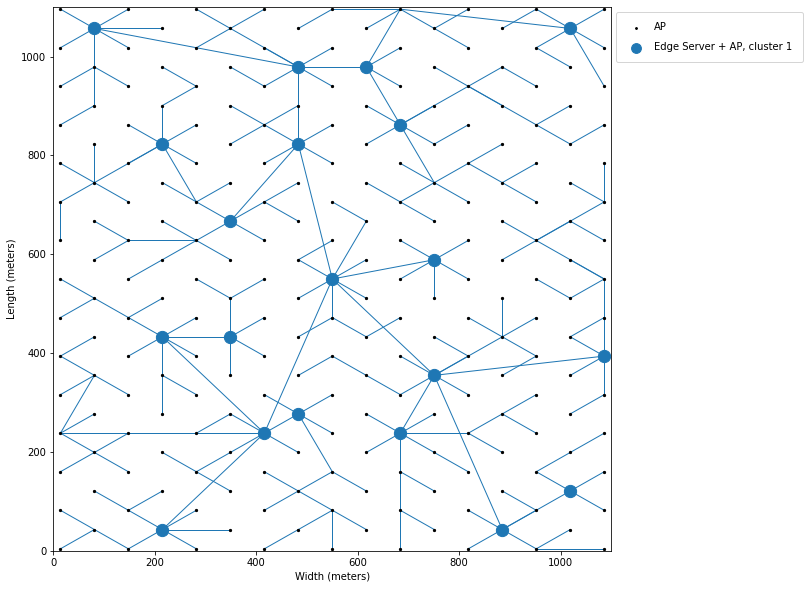

AP count: 247
Edge server count: 100
Clusters: 1


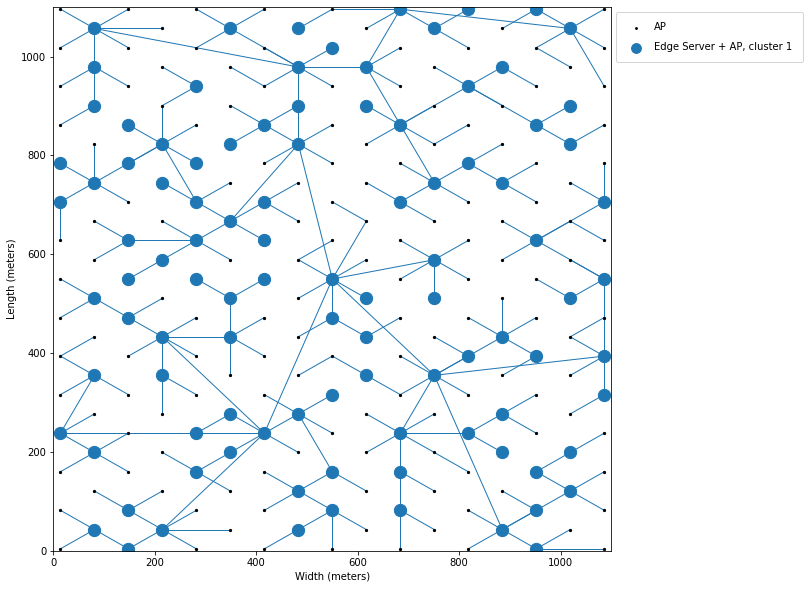

In [4]:
plot_server_clusters(AP_coords, s_coords_20, connections, np.array([0]*20), 1100, False)
plot_server_clusters(AP_coords, s_coords_100, connections, np.array([0]*100), 1100, False)

In [5]:
# Creating a topology graph
G = nx.Graph()
G.add_nodes_from(AP_coords)
G.add_edges_from(connections)

# Adding an attribute to each edge that tells the length of the edge in meters
distance_vals = {}
for e in G.edges():
    distance_vals[e] = euc_dist(e[0], e[1])
nx.set_edge_attributes(G, distance_vals, name='distance')

#nx.get_edge_attributes(G,'distance')

### Clustering 20 high capacity edge servers (agglomerative clustering)

The shortest path length in the topology is used as the distance metric between two servers.

In [6]:
dmat_20 = get_condensed_distance_matrix(s_coords_20, G)

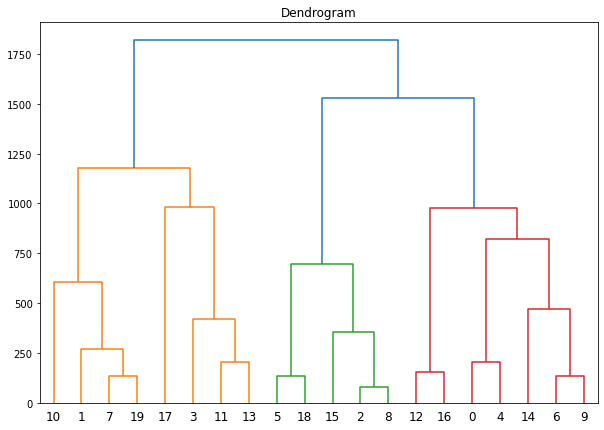

In [7]:
# Using ‘complete’ linkage, in which the maximum distances between all observations of the two sets are the criterion 
# that is minimized in merging a pair of clusters.

plt.figure(figsize=(10,7))
plt.title('Dendrogram')
linkage_method = linkage(dmat_20, method ='complete')
dend = dendrogram(linkage_method)

AP count: 247
Edge server count: 20
Clusters: 7


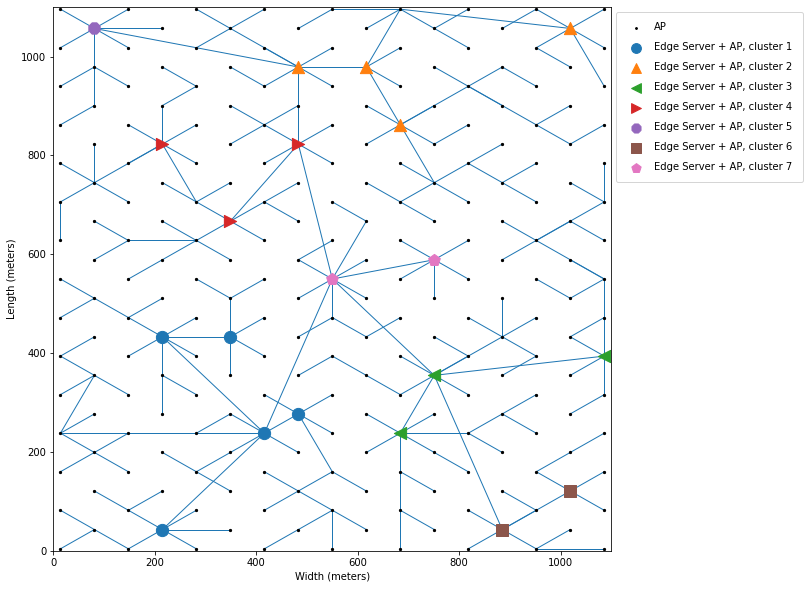

In [8]:
clusters_20 = AgglomerativeClustering(n_clusters=None, linkage='complete', affinity='precomputed', distance_threshold=700)
labels_20 = clusters_20.fit_predict(squareform(dmat_20))

plot_server_clusters(AP_coords, s_coords_20, connections, labels_20, 1100, False)

AP count: 247
Edge server count: 20
Clusters: 9


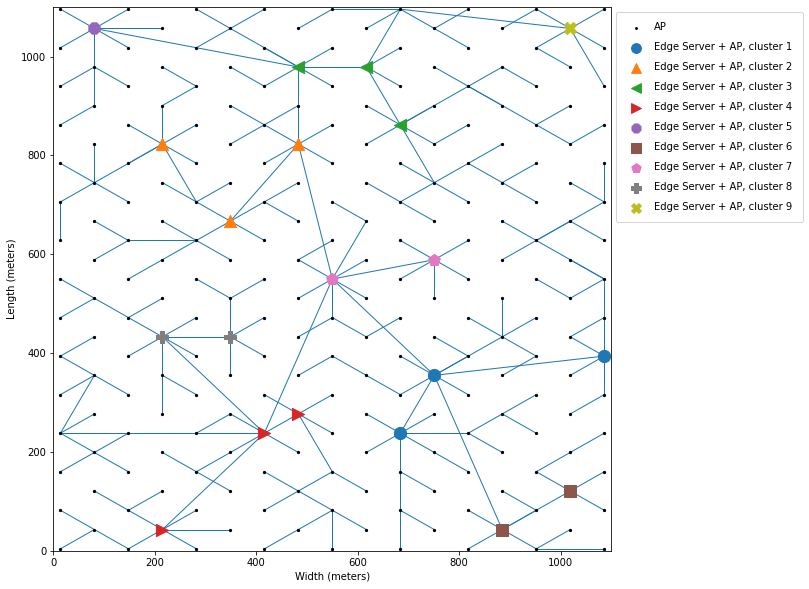

In [9]:
clusters_20 = AgglomerativeClustering(n_clusters=None, linkage='complete', affinity='precomputed', distance_threshold=550)
labels_20 = clusters_20.fit_predict(squareform(dmat_20))

plot_server_clusters(AP_coords, s_coords_20, connections, labels_20, 1100, False)

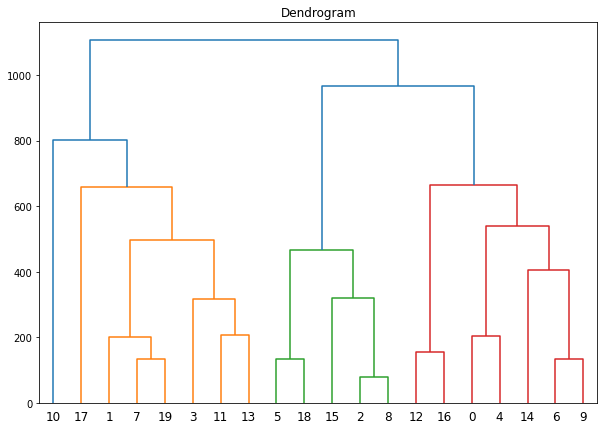

In [10]:
# Using ‘average’ linkage, in which the average of the distances of each observation of the two sets is the criterion 
# that is minimized in merging a pair of clusters.

plt.figure(figsize=(10,7))
plt.title('Dendrogram')
linkage_method = linkage(dmat_20, method ='average')
dend = dendrogram(linkage_method)

AP count: 247
Edge server count: 20
Clusters: 8


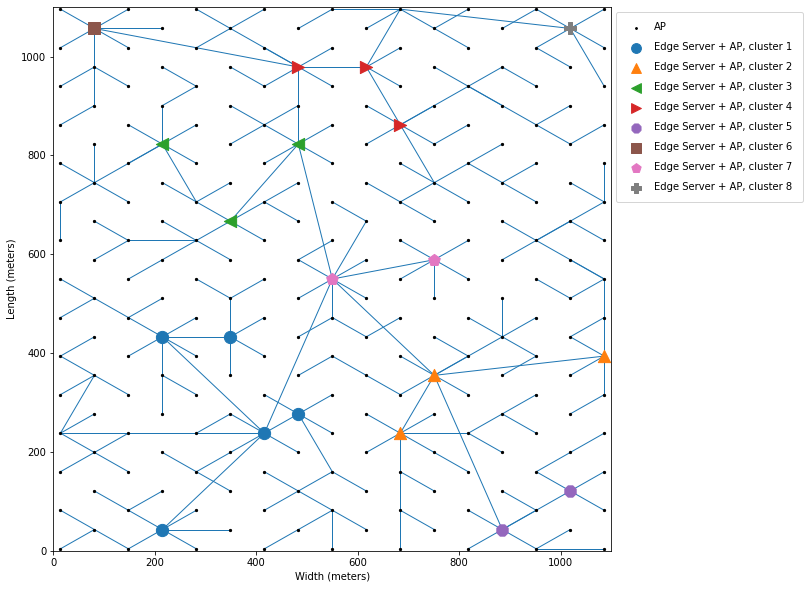

In [11]:
clusters_20 = AgglomerativeClustering(n_clusters=None, linkage='average', affinity='precomputed', distance_threshold=470)
labels_20 = clusters_20.fit_predict(squareform(dmat_20))

plot_server_clusters(AP_coords, s_coords_20, connections, labels_20, 1100, False)

### Clustering 100 low capacity edge servers (agglomerative clustering)

The shortest path length in the topology is used as the distance metric between two servers.

In [12]:
dmat_100 = get_condensed_distance_matrix(s_coords_100, G)

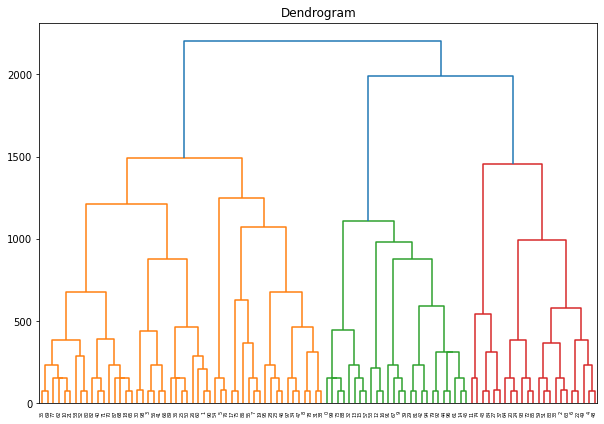

In [13]:
# Using ‘complete’ linkage, in which the maximum distances between all observations of the two sets are the criterion 
# that is minimized in merging a pair of clusters.

plt.figure(figsize=(10,7))
plt.title('Dendrogram')
linkage_method = linkage(dmat_100, method ='complete')
dend = dendrogram(linkage_method)

AP count: 247
Edge server count: 100
Clusters: 19


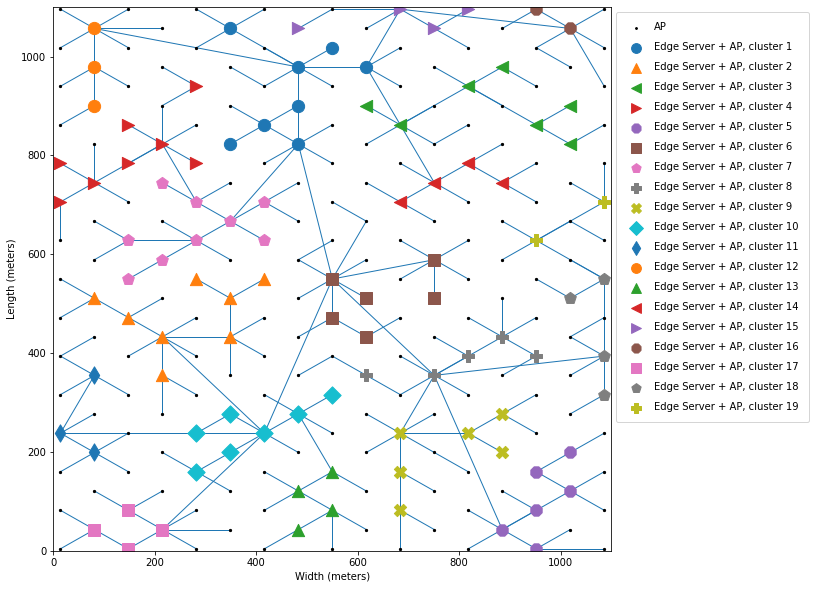

In [14]:
clusters_100 = AgglomerativeClustering(n_clusters=None, linkage='complete', affinity='precomputed', distance_threshold=500)
labels_100 = clusters_100.fit_predict(squareform(dmat_100))

plot_server_clusters(AP_coords, s_coords_100, connections, labels_100, 1100, False)

### Selecting cluster heads

In [15]:
def get_cluster_head_coords(server_locs, clusters, measures):
    '''
    Returns the coordinates of the cluster heads. 
    The heads are selected based on some measure values given in the parameter 'measures'. 
    Inside a cluster, the node with the biggest measure value is chosen as the cluster head.
    
    Args:
        server_locs (list): Edge server locations as a list of (x,y) tuples.
        clusters (list): A list of cluster labels (integers starting from zero) for each server in server_locs.
        measures (dict): A dictionary of measure values. The dictionary keys are server locations and 
                         the dictionary values are the corresponding measure values. 
    
    Returns:
        list: The coordinates of the cluster heads as a list of (x,y) tuples.
    '''
    cluster_heads = []
    cluster_count = max(clusters) + 1
    
    for i in range(cluster_count):
        cluster_indexes = np.where(clusters == i)[0]
        cluster_servers = [server_locs[k] for k in cluster_indexes]
        max_measure = -np.inf
        head = None
        for loc in cluster_servers:
            measure = measures[loc]
            if measure > max_measure:
                max_measure = measure
                head = loc
        cluster_heads.append(head)
    
    return cluster_heads

In [16]:
bc_measures = nx.betweenness_centrality(G) # The head of the cluster will be the node with highest betweenness centrality

AP count: 247
Edge server count: 20
Clusters: 8


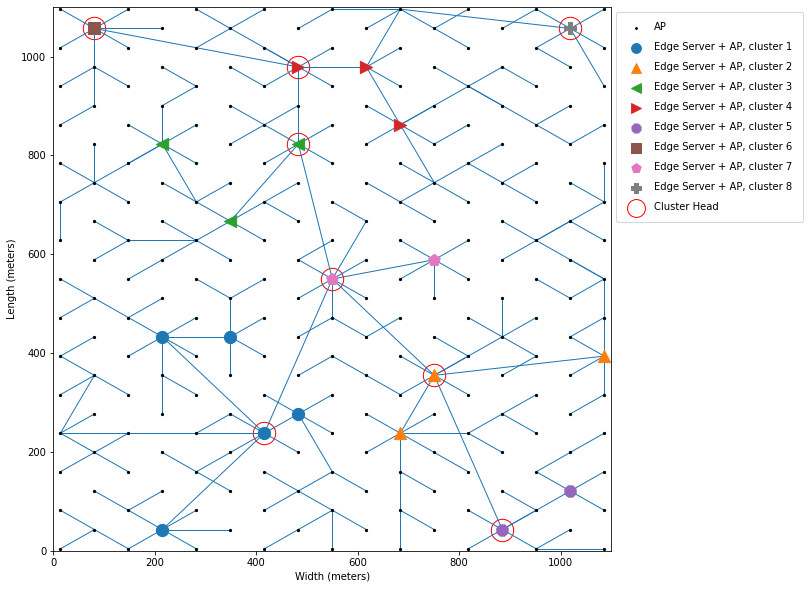

In [17]:
h_coords_20 = get_cluster_head_coords(s_coords_20, labels_20, bc_measures)
plot_server_clusters(AP_coords, s_coords_20, connections, labels_20, 1100, True, h_coords_20)

AP count: 247
Edge server count: 100
Clusters: 19


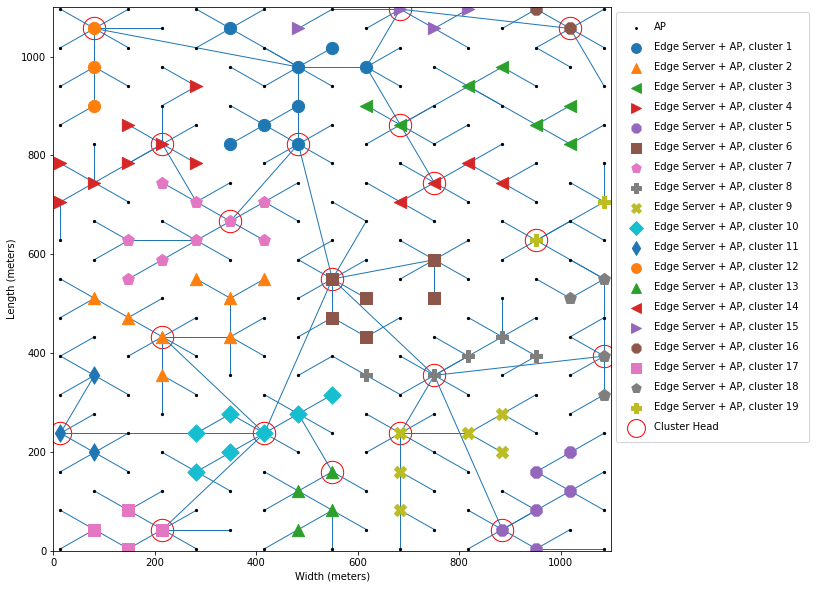

In [18]:
h_coords_100 = get_cluster_head_coords(s_coords_100, labels_100, bc_measures)
plot_server_clusters(AP_coords, s_coords_100, connections, labels_100, 1100, True, h_coords_100)

### Saving the cluster info to a JSON file

In [19]:
def get_cluster_info(s_coords, labels, h_coords):
    '''
    Returns a dictionary, where each key is the name of a server, and the value is another dictionary that gives the following
    information:
    The value of 'cluster' key is the label of the cluster (integer) to which the server belongs.
    The value of 'head' key is True if the server is a cluster head, otherwise False.
    
    Args:
        server_locs (list): Edge server locations as a list of (x,y) tuples.
        labels (list): A list of cluster labels (integers starting from zero) for each server in server_locs.
        h_coords (list): Cluster head locations as a list of (x,y) tuples.
    
    Returns:
        dict: A dictionary that contains the cluster info for each server.
    '''
    cluster_info = {}
    for i, loc in enumerate(s_coords):
        name = "dc{}".format(i+1)
        cluster_info[name] = {}
        dc = cluster_info[name]
        dc['cluster'] = int(labels[i]) # Changing the type from numpy int64 to inbuilt Python int
        dc['head'] = True if loc in h_coords else False
        #dc['location'] = loc
    return cluster_info

In [20]:
server_info_20 = get_cluster_info(s_coords_20, labels_20, h_coords_20)
server_info_100 = get_cluster_info(s_coords_100, labels_100, h_coords_100)

# Saving the cluster info as a JSON file
with open('server20_cluster_info.json', 'w', encoding ='utf8') as json_file:
    json.dump(server_info_20, json_file, indent=4)
    
with open('server100_cluster_info.json', 'w', encoding ='utf8') as json_file:
    json.dump(server_info_100, json_file, indent=4)